## Accumulated Local Effects for BLERSSI Location Prediction

## Clone Cisco Kubeflow Starter pack repository

In [1]:
BRANCH_NAME="dev" #Provide git branch name "master" or "dev"
! git clone -b $BRANCH_NAME https://github.com/CiscoAI/cisco-kubeflow-starter-pack.git

Cloning into 'cisco-kubeflow-starter-pack'...
remote: Enumerating objects: 479, done.
remote: Counting objects: 100% (479/479), done.
remote: Compressing objects: 100% (310/310), done.
remote: Total 4459 (delta 160), reused 347 (delta 95), pack-reused 3980
Receiving objects: 100% (4459/4459), 16.60 MiB | 6.03 MiB/s, done.
Resolving deltas: 100% (1665/1665), done.


In [2]:
! pip install pandas sklearn kfserving alibi --user

     |████████████████████████████████| 10.1 MB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 3.1 MB/s  eta 0:00:01
     |████████████████████████████████| 217 kB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 13.5 MB/s eta 0:00:01     |███████████████████▌            | 4.2 MB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 55 kB 5.1 MB/s  eta 0:00:01
     |████████████████████████████████| 10.0 MB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 115 kB 28.3 MB/s eta 0:00:01
     |████████████████████████████████| 273 kB 37.4 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 5.7 MB/s  eta 0:00:01
     |████████████████████████████████| 2.2 MB 39.5 MB/s eta 0:00:01
     |████████████████████████████████|

## Restart Notebook kernel

In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

## Import Libraries

In [1]:
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import pandas as pd
import numpy as np
import shutil
import yaml
import random
import re
import os
import logging
import requests
import json
from sklearn.preprocessing import OneHotEncoder

from alibi.explainers import AnchorTabular
from alibi.explainers import plot_ale
from alibi.explainers.ale import ALE, plot_ale

from kubernetes.client import V1Container
from kfserving import KFServingClient
from kfserving import constants
from kfserving import utils
from kfserving import V1alpha2EndpointSpec
from kfserving import V1alpha2PredictorSpec
from kfserving import V1alpha2InferenceServiceSpec
from kfserving import V1alpha2InferenceService
from kfserving import V1alpha2CustomSpec
from kfserving import V1alpha2Logger
from kfserving import V1alpha2TensorflowSpec
from kfserving import V1alpha2ExplainerSpec
from kfserving import V1alpha2AlibiExplainerSpec

from kubernetes import client as k8s_client
from kubernetes import config as k8s_config
from kubernetes.client.rest import ApiException

k8s_config.load_incluster_config()
api_client = k8s_client.CoreV1Api()
custom_api=k8s_client.CustomObjectsApi()
namespace = utils.get_default_target_namespace()
print(namespace)

anonymous


## Check GPUs availability

In [2]:
gpus = len(tf.config.experimental.list_physical_devices('GPU'))
if gpus == 0:
    print("Model will be trained using CPU")
elif gpus >= 0:
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    tf.config.experimental.list_physical_devices('GPU')
    print("Model will be trained using GPU")

Model will be trained using CPU


## Declare Variables

In [3]:
path="cisco-kubeflow-starter-pack/apps/networking/ble-localization/onprem"
BLE_RSSI = pd.read_csv(os.path.join(path, "data/iBeacon_RSSI_Labeled.csv")) #Labeled dataset

# Configure model options
TF_DATA_DIR = os.getenv("TF_DATA_DIR", "/tmp/data/")
TF_MODEL_DIR = os.getenv("TF_MODEL_DIR", "blerssi/")
TF_EXPORT_DIR = os.getenv("TF_EXPORT_DIR", "blerssi/")
TF_MODEL_TYPE = os.getenv("TF_MODEL_TYPE", "DNN")
TF_TRAIN_STEPS = int(os.getenv("TF_TRAIN_STEPS", 5000))
TF_BATCH_SIZE = int(os.getenv("TF_BATCH_SIZE", 128))
TF_LEARNING_RATE = float(os.getenv("TF_LEARNING_RATE", 0.001))


# Feature columns
COLUMNS = list(BLE_RSSI.columns)
FEATURES = COLUMNS[2:]
def make_feature_cols():
  input_columns = [tf.feature_column.numeric_column(k) for k in FEATURES]
  return input_columns

## BLERSSI Input Dataset
### Attribute Information
location: The location of receiving RSSIs from ibeacons b3001 to b3013; 
          symbolic values showing the column and row of the location on the map (e.g., A01 stands for column A, row 1).
date: Datetime in the format of ‘d-m-yyyy hh:mm:ss’
b3001 - b3013: RSSI readings corresponding to the iBeacons; numeric, integers only.

In [4]:
BLE_RSSI.head(10)

,location,date,b3001,b3002,b3003,b3004,b3005,b3006,b3007,b3008,b3009,b3010,b3011,b3012,b3013
0,O02,10-18-2016 11:15:21,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200
1,P01,10-18-2016 11:15:19,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200
2,P01,10-18-2016 11:15:17,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200
3,P01,10-18-2016 11:15:15,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200
4,P01,10-18-2016 11:15:13,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200
5,P01,10-18-2016 11:15:11,-200,-200,-82,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
6,P01,10-18-2016 11:15:09,-200,-200,-80,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200
7,P02,10-18-2016 11:15:07,-200,-200,-86,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
8,R01,10-18-2016 11:15:05,-200,-200,-200,-75,-200,-200,-200,-200,-200,-200,-200,-200,-200
9,R01,10-18-2016 11:15:03,-200,-200,-200,-75,-200,-200,-200,-200,-200,-200,-200,-200,-200


## Definition of Serving Input Receiver Function

In [5]:
feature_columns =  make_feature_cols()
inputs = {}
for feat in feature_columns:
  inputs[feat.name] = tf.placeholder(shape=[None], dtype=feat.dtype)
serving_input_receiver_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(inputs)

## Train and Save BLE RSSI Model

In [6]:
# Feature columns
COLUMNS = list(BLE_RSSI.columns)
FEATURES = COLUMNS[2:]
LABEL = [COLUMNS[0]]

b3001 = tf.feature_column.numeric_column(key='b3001',dtype=tf.float64)
b3002 = tf.feature_column.numeric_column(key='b3002',dtype=tf.float64)
b3003 = tf.feature_column.numeric_column(key='b3003',dtype=tf.float64)
b3004 = tf.feature_column.numeric_column(key='b3004',dtype=tf.float64)
b3005 = tf.feature_column.numeric_column(key='b3005',dtype=tf.float64)
b3006 = tf.feature_column.numeric_column(key='b3006',dtype=tf.float64)
b3007 = tf.feature_column.numeric_column(key='b3007',dtype=tf.float64)
b3008 = tf.feature_column.numeric_column(key='b3008',dtype=tf.float64)
b3009 = tf.feature_column.numeric_column(key='b3009',dtype=tf.float64)
b3010 = tf.feature_column.numeric_column(key='b3010',dtype=tf.float64)
b3011 = tf.feature_column.numeric_column(key='b3011',dtype=tf.float64)
b3012 = tf.feature_column.numeric_column(key='b3012',dtype=tf.float64)
b3013 = tf.feature_column.numeric_column(key='b3013',dtype=tf.float64)
feature_columns = [b3001, b3002, b3003, b3004, b3005, b3006, b3007, b3008, b3009, b3010, b3011, b3012, b3013]

df_full = pd.read_csv(os.path.join(path, "data/iBeacon_RSSI_Labeled.csv")) #Labeled dataset

# Input Data Preprocessing 
df_full = df_full.drop(['date'],axis = 1)
df_full[FEATURES] = (df_full[FEATURES])/(-200)


#Output Data Preprocessing
dict = {'O02': 0,'P01': 1,'P02': 2,'R01': 3,'R02': 4,'S01': 5,'S02': 6,'T01': 7,'U02': 8,'U01': 9,'J03': 10,'K03': 11,'L03': 12,'M03': 13,'N03': 14,'O03': 15,'P03': 16,'Q03': 17,'R03': 18,'S03': 19,'T03': 20,'U03': 21,'U04': 22,'T04': 23,'S04': 24,'R04': 25,'Q04': 26,'P04': 27,'O04': 28,'N04': 29,'M04': 30,'L04': 31,'K04': 32,'J04': 33,'I04': 34,'I05': 35,'J05': 36,'K05': 37,'L05': 38,'M05': 39,'N05': 40,'O05': 41,'P05': 42,'Q05': 43,'R05': 44,'S05': 45,'T05': 46,'U05': 47,'S06': 48,'R06': 49,'Q06': 50,'P06': 51,'O06': 52,'N06': 53,'M06': 54,'L06': 55,'K06': 56,'J06': 57,'I06': 58,'F08': 59,'J02': 60,'J07': 61,'I07': 62,'I10': 63,'J10': 64,'D15': 65,'E15': 66,'G15': 67,'J15': 68,'L15': 69,'R15': 70,'T15': 71,'W15': 72,'I08': 73,'I03': 74,'J08': 75,'I01': 76,'I02': 77,'J01': 78,'K01': 79,'K02': 80,'L01': 81,'L02': 82,'M01': 83,'M02': 84,'N01': 85,'N02': 86,'O01': 87,'I09': 88,'D14': 89,'D13': 90,'K07': 91,'K08': 92,'N15': 93,'P15': 94,'I15': 95,'S15': 96,'U15': 97,'V15': 98,'S07': 99,'S08': 100,'L09': 101,'L08': 102,'Q02': 103,'Q01': 104}
df_full['location'] = df_full['location'].map(dict)
df_train=df_full.sample(frac=0.8,random_state=200)
df_valid=df_full.drop(df_train.index)

location_counts = BLE_RSSI.location.value_counts()
x1 = np.asarray(df_train[FEATURES])
y1 = np.asarray(df_train['location'])

x2 = np.asarray(df_valid[FEATURES])
y2 = np.asarray(df_valid['location'])

def formatFeatures(features):
    formattedFeatures = {}
    numColumns = features.shape[1]

    for i in range(0, numColumns):
        formattedFeatures["b"+str(3001+i)] = features[:, i]

    return formattedFeatures

trainingFeatures = formatFeatures(x1)
trainingCategories = y1

testFeatures = formatFeatures(x2)
testCategories = y2

# Train Input Function
def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((trainingFeatures, y1))
    dataset = dataset.repeat(1000).batch(TF_BATCH_SIZE)
    return dataset

# Test Input Function
def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((testFeatures, y2))
    return dataset.repeat(1000).batch(TF_BATCH_SIZE)

# Provide list of GPUs should be used to train the model

distribution=tf.distribute.experimental.ParameterServerStrategy()
print('Number of devices: {}'.format(distribution.num_replicas_in_sync))

# Configuration of  training model

config = tf.estimator.RunConfig(train_distribute=distribution, model_dir=TF_MODEL_DIR, save_summary_steps=100, save_checkpoints_steps=100)

# Build 3 layer DNN classifier

model = tf.estimator.DNNClassifier(hidden_units = [13,65,110],
                 feature_columns = feature_columns,
                 model_dir = TF_MODEL_DIR,
                 n_classes=105, config=config
               )

export_final = tf.estimator.FinalExporter(TF_EXPORT_DIR, serving_input_receiver_fn=serving_input_receiver_fn)

train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, 
                                    max_steps=TF_TRAIN_STEPS)

eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn,
                                  steps=100,
                                  exporters=export_final,
                                  throttle_secs=1,
                                  start_delay_secs=1)

# Train and Evaluate the model

tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

INFO:tensorflow:ParameterServerStrategy with compute_devices = ('/device:CPU:0',), variable_device = '/device:CPU:0'


[I 200713 09:19:15 parameter_server_strategy:294] ParameterServerStrategy with compute_devices = ('/device:CPU:0',), variable_device = '/device:CPU:0'


Number of devices: 1
INFO:tensorflow:Initializing RunConfig with distribution strategies.


[I 200713 09:19:15 run_config:566] Initializing RunConfig with distribution strategies.


INFO:tensorflow:Not using Distribute Coordinator.


[I 200713 09:19:15 estimator_training:167] Not using Distribute Coordinator.


INFO:tensorflow:Using config: {'_model_dir': 'blerssi/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.parameter_server_strategy.ParameterServerStrategyV1 object at 0x7fb0c42a16a0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb0c42a1940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1,

[I 200713 09:19:15 estimator:212] Using config: {'_model_dir': 'blerssi/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
    graph_options {
      rewrite_options {
        meta_optimizer_iterations: ONE
      }
    }
    , '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.parameter_server_strategy.ParameterServerStrategyV1 object at 0x7fb0c42a16a0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb0c42a1940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_p

INFO:tensorflow:Not using Distribute Coordinator.


[I 200713 09:19:15 estimator_training:186] Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


[I 200713 09:19:15 training:612] Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 100 or save_checkpoints_secs None.


[I 200713 09:19:15 training:700] Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 100 or save_checkpoints_secs None.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[W 200713 09:19:15 deprecation:506] From /home/jovyan/.local/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
    Instructions for updating:
    If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Calling model_fn.


[I 200713 09:19:15 estimator:1148] Calling model_fn.


Instructions for updating:
Use `tf.cast` instead.


[W 200713 09:19:16 deprecation:323] From /home/jovyan/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/canned/head.py:437: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
    Instructions for updating:
    Use `tf.cast` instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


[W 200713 09:19:16 deprecation:506] From /home/jovyan/.local/lib/python3.6/site-packages/tensorflow_core/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
    Instructions for updating:
    Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


[I 200713 09:19:17 estimator:1150] Done calling model_fn.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[W 200713 09:19:17 deprecation:323] From /home/jovyan/.local/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
    Instructions for updating:
    Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Create CheckpointSaverHook.


[I 200713 09:19:17 basic_session_run_hooks:541] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


[I 200713 09:19:17 monitored_session:240] Graph was finalized.


INFO:tensorflow:Running local_init_op.


[I 200713 09:19:17 session_manager:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


[I 200713 09:19:17 session_manager:502] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into blerssi/model.ckpt.


[I 200713 09:19:17 basic_session_run_hooks:606] Saving checkpoints for 0 into blerssi/model.ckpt.


INFO:tensorflow:loss = 598.8238, step = 0


[I 200713 09:19:18 basic_session_run_hooks:262] loss = 598.8238, step = 0


INFO:tensorflow:Saving checkpoints for 100 into blerssi/model.ckpt.


[I 200713 09:19:18 basic_session_run_hooks:606] Saving checkpoints for 100 into blerssi/model.ckpt.


INFO:tensorflow:Calling model_fn.


[I 200713 09:19:18 estimator:1148] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


[I 200713 09:19:19 estimator:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-07-13T09:19:19Z


[I 200713 09:19:19 evaluation:255] Starting evaluation at 2020-07-13T09:19:19Z


INFO:tensorflow:Graph was finalized.


[I 200713 09:19:19 monitored_session:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from blerssi/model.ckpt-100


[I 200713 09:19:19 saver:1284] Restoring parameters from blerssi/model.ckpt-100


INFO:tensorflow:Running local_init_op.


[I 200713 09:19:19 session_manager:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


[I 200713 09:19:19 session_manager:502] Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


[I 200713 09:19:19 evaluation:167] Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


[I 200713 09:19:19 evaluation:167] Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


[I 200713 09:19:19 evaluation:167] Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


[I 200713 09:19:20 evaluation:167] Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


[I 200713 09:19:20 evaluation:167] Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


[I 200713 09:19:20 evaluation:167] Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


[I 200713 09:19:20 evaluation:167] Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


[I 200713 09:19:20 evaluation:167] Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


[I 200713 09:19:20 evaluation:167] Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


[I 200713 09:19:20 evaluation:167] Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2020-07-13-09:19:20


[I 200713 09:19:20 evaluation:275] Finished evaluation at 2020-07-13-09:19:20


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.1759375, average_loss = 3.099626, global_step = 100, loss = 396.75214


[I 200713 09:19:20 estimator:2049] Saving dict for global step 100: accuracy = 0.1759375, average_loss = 3.099626, global_step = 100, loss = 396.75214


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: blerssi/model.ckpt-100


[I 200713 09:19:20 estimator:2109] Saving 'checkpoint_path' summary for global step 100: blerssi/model.ckpt-100


INFO:tensorflow:global_step/sec: 49.4485


[I 200713 09:19:20 basic_session_run_hooks:692] global_step/sec: 49.4485


INFO:tensorflow:loss = 375.98376, step = 100 (2.025 sec)


[I 200713 09:19:20 basic_session_run_hooks:260] loss = 375.98376, step = 100 (2.025 sec)


INFO:tensorflow:Saving checkpoints for 200 into blerssi/model.ckpt.


[I 200713 09:19:20 basic_session_run_hooks:606] Saving checkpoints for 200 into blerssi/model.ckpt.


INFO:tensorflow:Calling model_fn.


[I 200713 09:19:20 estimator:1148] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


[I 200713 09:19:21 estimator:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-07-13T09:19:21Z


[I 200713 09:19:21 evaluation:255] Starting evaluation at 2020-07-13T09:19:21Z


INFO:tensorflow:Graph was finalized.


[I 200713 09:19:21 monitored_session:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from blerssi/model.ckpt-200


[I 200713 09:19:21 saver:1284] Restoring parameters from blerssi/model.ckpt-200


INFO:tensorflow:Running local_init_op.


[I 200713 09:19:21 session_manager:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


[I 200713 09:19:21 session_manager:502] Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


[I 200713 09:19:21 evaluation:167] Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


[I 200713 09:19:21 evaluation:167] Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


[I 200713 09:19:21 evaluation:167] Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


[I 200713 09:19:21 evaluation:167] Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


[I 200713 09:19:21 evaluation:167] Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


[I 200713 09:19:21 evaluation:167] Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


[I 200713 09:19:21 evaluation:167] Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


[I 200713 09:19:21 evaluation:167] Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


[I 200713 09:19:21 evaluation:167] Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


[I 200713 09:19:21 evaluation:167] Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2020-07-13-09:19:21


[I 200713 09:19:21 evaluation:275] Finished evaluation at 2020-07-13-09:19:21


INFO:tensorflow:Saving dict for global step 200: accuracy = 0.17601563, average_loss = 2.9182034, global_step = 200, loss = 373.53003


[I 200713 09:19:21 estimator:2049] Saving dict for global step 200: accuracy = 0.17601563, average_loss = 2.9182034, global_step = 200, loss = 373.53003


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: blerssi/model.ckpt-200


[I 200713 09:19:21 estimator:2109] Saving 'checkpoint_path' summary for global step 200: blerssi/model.ckpt-200


INFO:tensorflow:global_step/sec: 61.9487


[I 200713 09:19:21 basic_session_run_hooks:692] global_step/sec: 61.9487


INFO:tensorflow:loss = 349.52896, step = 200 (1.615 sec)


[I 200713 09:19:21 basic_session_run_hooks:260] loss = 349.52896, step = 200 (1.615 sec)


[W 200713 09:19:22 basic_session_run_hooks:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 233 vs previous value: 233. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


INFO:tensorflow:Saving checkpoints for 300 into blerssi/model.ckpt.


[I 200713 09:19:22 basic_session_run_hooks:606] Saving checkpoints for 300 into blerssi/model.ckpt.


INFO:tensorflow:Calling model_fn.


[I 200713 09:19:22 estimator:1148] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


[I 200713 09:19:22 estimator:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-07-13T09:19:22Z


[I 200713 09:19:22 evaluation:255] Starting evaluation at 2020-07-13T09:19:22Z


INFO:tensorflow:Graph was finalized.


[I 200713 09:19:22 monitored_session:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from blerssi/model.ckpt-300


[I 200713 09:19:22 saver:1284] Restoring parameters from blerssi/model.ckpt-300


INFO:tensorflow:Running local_init_op.


[I 200713 09:19:22 session_manager:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


[I 200713 09:19:22 session_manager:502] Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


[I 200713 09:19:23 evaluation:167] Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


[I 200713 09:19:23 evaluation:167] Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


[I 200713 09:19:23 evaluation:167] Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


[I 200713 09:19:23 evaluation:167] Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


[I 200713 09:19:23 evaluation:167] Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


[I 200713 09:19:23 evaluation:167] Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


[I 200713 09:19:23 evaluation:167] Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


[I 200713 09:19:23 evaluation:167] Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


[I 200713 09:19:23 evaluation:167] Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


[I 200713 09:19:23 evaluation:167] Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2020-07-13-09:19:23


[I 200713 09:19:23 evaluation:275] Finished evaluation at 2020-07-13-09:19:23


INFO:tensorflow:Saving dict for global step 300: accuracy = 0.1653125, average_loss = 3.0257382, global_step = 300, loss = 387.2945


[I 200713 09:19:23 estimator:2049] Saving dict for global step 300: accuracy = 0.1653125, average_loss = 3.0257382, global_step = 300, loss = 387.2945


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 300: blerssi/model.ckpt-300


[I 200713 09:19:23 estimator:2109] Saving 'checkpoint_path' summary for global step 300: blerssi/model.ckpt-300


INFO:tensorflow:global_step/sec: 66.0304


[I 200713 09:19:23 basic_session_run_hooks:692] global_step/sec: 66.0304


INFO:tensorflow:loss = 357.3448, step = 300 (1.513 sec)


[I 200713 09:19:23 basic_session_run_hooks:260] loss = 357.3448, step = 300 (1.513 sec)


INFO:tensorflow:Saving checkpoints for 400 into blerssi/model.ckpt.


[I 200713 09:19:23 basic_session_run_hooks:606] Saving checkpoints for 400 into blerssi/model.ckpt.


INFO:tensorflow:Calling model_fn.


[I 200713 09:19:23 estimator:1148] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


[I 200713 09:19:24 estimator:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-07-13T09:19:24Z


[I 200713 09:19:24 evaluation:255] Starting evaluation at 2020-07-13T09:19:24Z


INFO:tensorflow:Graph was finalized.


[I 200713 09:19:24 monitored_session:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from blerssi/model.ckpt-400


[I 200713 09:19:24 saver:1284] Restoring parameters from blerssi/model.ckpt-400


INFO:tensorflow:Running local_init_op.


[I 200713 09:19:24 session_manager:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


[I 200713 09:19:24 session_manager:502] Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


[I 200713 09:19:24 evaluation:167] Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


[I 200713 09:19:24 evaluation:167] Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


[I 200713 09:19:24 evaluation:167] Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


[I 200713 09:19:24 evaluation:167] Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


[I 200713 09:19:24 evaluation:167] Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


[I 200713 09:19:24 evaluation:167] Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


[I 200713 09:19:24 evaluation:167] Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


[I 200713 09:19:24 evaluation:167] Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


[I 200713 09:19:24 evaluation:167] Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


[I 200713 09:19:24 evaluation:167] Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2020-07-13-09:19:24


[I 200713 09:19:24 evaluation:275] Finished evaluation at 2020-07-13-09:19:24


INFO:tensorflow:Saving dict for global step 400: accuracy = 0.15828125, average_loss = 2.8854628, global_step = 400, loss = 369.33923


[I 200713 09:19:24 estimator:2049] Saving dict for global step 400: accuracy = 0.15828125, average_loss = 2.8854628, global_step = 400, loss = 369.33923


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 400: blerssi/model.ckpt-400


[I 200713 09:19:24 estimator:2109] Saving 'checkpoint_path' summary for global step 400: blerssi/model.ckpt-400


INFO:tensorflow:global_step/sec: 66.2429


[I 200713 09:19:24 basic_session_run_hooks:692] global_step/sec: 66.2429


INFO:tensorflow:loss = 323.43665, step = 400 (1.510 sec)


[I 200713 09:19:24 basic_session_run_hooks:260] loss = 323.43665, step = 400 (1.510 sec)


INFO:tensorflow:Saving checkpoints for 500 into blerssi/model.ckpt.


[I 200713 09:19:25 basic_session_run_hooks:606] Saving checkpoints for 500 into blerssi/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


[W 200713 09:19:25 deprecation:323] From /home/jovyan/.local/lib/python3.6/site-packages/tensorflow_core/python/training/saver.py:963: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
    Instructions for updating:
    Use standard file APIs to delete files with this prefix.
[I 200713 09:20:39 estimator:2049] Saving dict for global step 5000: accuracy = 0.2675, average_loss = 3.0981607, global_step = 5000, loss = 396.56458


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: blerssi/model.ckpt-5000


[I 200713 09:20:39 estimator:2109] Saving 'checkpoint_path' summary for global step 5000: blerssi/model.ckpt-5000


INFO:tensorflow:Performing the final export in the end of training.


[I 200713 09:20:39 exporter:410] Performing the final export in the end of training.


INFO:tensorflow:Calling model_fn.


[I 200713 09:20:39 estimator:1148] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


[I 200713 09:20:39 estimator:1150] Done calling model_fn.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


[W 200713 09:20:39 deprecation:323] From /home/jovyan/.local/lib/python3.6/site-packages/tensorflow_core/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
    Instructions for updating:
    This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


[I 200713 09:20:39 export_utils:170] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


[I 200713 09:20:39 export_utils:170] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']


[I 200713 09:20:39 export_utils:170] Signatures INCLUDED in export for Predict: ['predict']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


[I 200713 09:20:39 export_utils:170] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


[I 200713 09:20:39 export_utils:170] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:


[I 200713 09:20:39 export_utils:173] Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:


INFO:tensorflow:'serving_default' : Classification input must be a single string Tensor; got {'b3001': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=float32>, 'b3002': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>, 'b3003': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=float32>, 'b3004': <tf.Tensor 'Placeholder_3:0' shape=(?,) dtype=float32>, 'b3005': <tf.Tensor 'Placeholder_4:0' shape=(?,) dtype=float32>, 'b3006': <tf.Tensor 'Placeholder_5:0' shape=(?,) dtype=float32>, 'b3007': <tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=float32>, 'b3008': <tf.Tensor 'Placeholder_7:0' shape=(?,) dtype=float32>, 'b3009': <tf.Tensor 'Placeholder_8:0' shape=(?,) dtype=float32>, 'b3010': <tf.Tensor 'Placeholder_9:0' shape=(?,) dtype=float32>, 'b3011': <tf.Tensor 'Placeholder_10:0' shape=(?,) dtype=float32>, 'b3012': <tf.Tensor 'Placeholder_11:0' shape=(?,) dtype=float32>, 'b3013': <tf.Tensor 'Placeholder_12:0' shape=(?,) dtype=float32>}


[I 200713 09:20:39 export_utils:176] 'serving_default' : Classification input must be a single string Tensor; got {'b3001': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=float32>, 'b3002': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>, 'b3003': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=float32>, 'b3004': <tf.Tensor 'Placeholder_3:0' shape=(?,) dtype=float32>, 'b3005': <tf.Tensor 'Placeholder_4:0' shape=(?,) dtype=float32>, 'b3006': <tf.Tensor 'Placeholder_5:0' shape=(?,) dtype=float32>, 'b3007': <tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=float32>, 'b3008': <tf.Tensor 'Placeholder_7:0' shape=(?,) dtype=float32>, 'b3009': <tf.Tensor 'Placeholder_8:0' shape=(?,) dtype=float32>, 'b3010': <tf.Tensor 'Placeholder_9:0' shape=(?,) dtype=float32>, 'b3011': <tf.Tensor 'Placeholder_10:0' shape=(?,) dtype=float32>, 'b3012': <tf.Tensor 'Placeholder_11:0' shape=(?,) dtype=float32>, 'b3013': <tf.Tensor 'Placeholder_12:0' shape=(?,) dtype=float32>}


INFO:tensorflow:'classification' : Classification input must be a single string Tensor; got {'b3001': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=float32>, 'b3002': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>, 'b3003': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=float32>, 'b3004': <tf.Tensor 'Placeholder_3:0' shape=(?,) dtype=float32>, 'b3005': <tf.Tensor 'Placeholder_4:0' shape=(?,) dtype=float32>, 'b3006': <tf.Tensor 'Placeholder_5:0' shape=(?,) dtype=float32>, 'b3007': <tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=float32>, 'b3008': <tf.Tensor 'Placeholder_7:0' shape=(?,) dtype=float32>, 'b3009': <tf.Tensor 'Placeholder_8:0' shape=(?,) dtype=float32>, 'b3010': <tf.Tensor 'Placeholder_9:0' shape=(?,) dtype=float32>, 'b3011': <tf.Tensor 'Placeholder_10:0' shape=(?,) dtype=float32>, 'b3012': <tf.Tensor 'Placeholder_11:0' shape=(?,) dtype=float32>, 'b3013': <tf.Tensor 'Placeholder_12:0' shape=(?,) dtype=float32>}


[I 200713 09:20:39 export_utils:176] 'classification' : Classification input must be a single string Tensor; got {'b3001': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=float32>, 'b3002': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>, 'b3003': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=float32>, 'b3004': <tf.Tensor 'Placeholder_3:0' shape=(?,) dtype=float32>, 'b3005': <tf.Tensor 'Placeholder_4:0' shape=(?,) dtype=float32>, 'b3006': <tf.Tensor 'Placeholder_5:0' shape=(?,) dtype=float32>, 'b3007': <tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=float32>, 'b3008': <tf.Tensor 'Placeholder_7:0' shape=(?,) dtype=float32>, 'b3009': <tf.Tensor 'Placeholder_8:0' shape=(?,) dtype=float32>, 'b3010': <tf.Tensor 'Placeholder_9:0' shape=(?,) dtype=float32>, 'b3011': <tf.Tensor 'Placeholder_10:0' shape=(?,) dtype=float32>, 'b3012': <tf.Tensor 'Placeholder_11:0' shape=(?,) dtype=float32>, 'b3013': <tf.Tensor 'Placeholder_12:0' shape=(?,) dtype=float32>}


[W 200713 09:20:39 export_utils:182] Export includes no default signature!


INFO:tensorflow:Restoring parameters from blerssi/model.ckpt-5000


[I 200713 09:20:39 saver:1284] Restoring parameters from blerssi/model.ckpt-5000


INFO:tensorflow:Assets added to graph.


[I 200713 09:20:39 builder_impl:665] Assets added to graph.


INFO:tensorflow:No assets to write.


[I 200713 09:20:39 builder_impl:460] No assets to write.


INFO:tensorflow:SavedModel written to: blerssi/export/blerssi/temp-b'1594632039'/saved_model.pb


[I 200713 09:20:39 builder_impl:425] SavedModel written to: blerssi/export/blerssi/temp-b'1594632039'/saved_model.pb


INFO:tensorflow:Loss for final step: 262.4268.


[I 200713 09:20:39 estimator:371] Loss for final step: 262.4268.


({'accuracy': 0.2675,
  'average_loss': 3.0981607,
  'loss': 396.56458,
  'global_step': 5000},
 [b'blerssi/export/blerssi/1594632039'])

## Define predict function

In [7]:
MODEL_EXPORT_PATH= os.path.join(TF_MODEL_DIR, "export", TF_EXPORT_DIR)

def logit(request):
    return predict(request, flag="logits")
    
def probs(request):
    return predict(request, flag="probabilities")
    
def predict(request, flag):
    
    # Get model exporter path
    for dir in os.listdir(MODEL_EXPORT_PATH):
        if re.match('[0-9]',dir):
            exported_path=os.path.join(MODEL_EXPORT_PATH,dir)
            break
    else:
        raise Exception("Model path not found")

    # Prepare model input data
    feature_cols=["b3001", "b3002","b3003","b3004","b3005","b3006","b3007","b3008","b3009","b3010","b3011","b3012","b3013"]
    input={'b3001': [], 'b3002': [], 'b3003': [], 'b3004': [], 'b3005': [], 'b3006': [], 'b3007': [], 'b3008': [], 'b3009': [], 'b3010': [], 'b3011': [], 'b3012': [], 'b3013': []}

    X=request
    if np.ndim(X) != 2:
        for i in range(len(X)):
            input[feature_cols[i]].append(X[i])
    else:
        for i in range(len(X)):
            for j in range(len(X[i])):
                input[feature_cols[j]].append(X[i][j])

    # Open a Session to predict
    with tf.Session() as sess:
        tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], exported_path)
        predictor= tf.contrib.predictor.from_saved_model(exported_path,signature_def_key='predict')
        output_dict= predictor(input)
    sess.close()
    output={}
    output["predictions"]={flag:output_dict[flag].tolist()}
    return np.asarray(output['predictions'][flag])

## Calculate Accumulated Local Effects

In [8]:
feature_cols=["b3001", "b3002", "b3003", "b3004", "b3005", "b3006", "b3007", "b3008", "b3009", "b3010", "b3011", "b3012", "b3013"]
target_names=[]
for i in range(4):
    target_names.append("c_%s"%random.randint(0,104))
print(target_names)
logits_ale=ALE(logit, feature_names=feature_cols, target_names=target_names)
probs_ale=ALE(probs, feature_names=feature_cols, target_names=target_names)

['c_17', 'c_88', 'c_62', 'c_46']


In [9]:
logits_exp = logits_ale.explain(x1)
probs_exp = probs_ale.explain(x1)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


[W 200713 09:21:04 deprecation:323] From <ipython-input-7-5d9ce6ee37e5>:34: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
    Instructions for updating:
    This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


INFO:tensorflow:Restoring parameters from blerssi/export/blerssi/1594632039/variables/variables


[I 200713 09:21:04 saver:1284] Restoring parameters from blerssi/export/blerssi/1594632039/variables/variables


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



[W 200713 09:21:04 lazy_loader:50] 
    The TensorFlow contrib module will not be included in TensorFlow 2.0.
    For more information, please see:
      * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
      * https://github.com/tensorflow/addons
      * https://github.com/tensorflow/io (for I/O related ops)
    If you depend on functionality not listed there, please file an issue.
    


INFO:tensorflow:Restoring parameters from blerssi/export/blerssi/1594632039/variables/variables


[I 200713 09:21:04 saver:1284] Restoring parameters from blerssi/export/blerssi/1594632039/variables/variables


INFO:tensorflow:Restoring parameters from blerssi/export/blerssi/1594632039/variables/variables


[I 200713 09:21:04 saver:1284] Restoring parameters from blerssi/export/blerssi/1594632039/variables/variables


INFO:tensorflow:Restoring parameters from blerssi/export/blerssi/1594632039/variables/variables


[I 200713 09:21:05 saver:1284] Restoring parameters from blerssi/export/blerssi/1594632039/variables/variables


INFO:tensorflow:Restoring parameters from blerssi/export/blerssi/1594632039/variables/variables


[I 200713 09:22:50 saver:1284] Restoring parameters from blerssi/export/blerssi/1594632039/variables/variables


## ALE in logit space
We first look at the ALE plots for explaining the feature effects towards the unnormalized logit scores

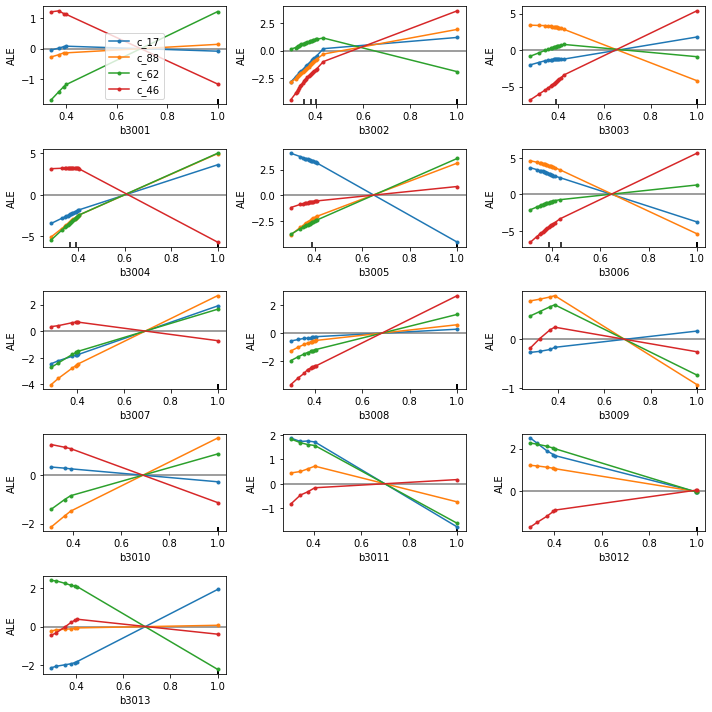

In [10]:
plot_ale(logits_exp,fig_kw={'figwidth': 10, 'figheight': 10}, sharey=None);

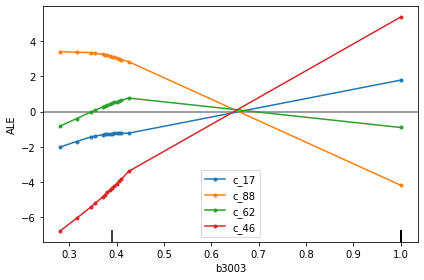

In [11]:
plot_ale(logits_exp, features=[2]);

## ALE in probability space
We now turn to interprting the ALE plots for explaining the feature effects on the probabilities of each class

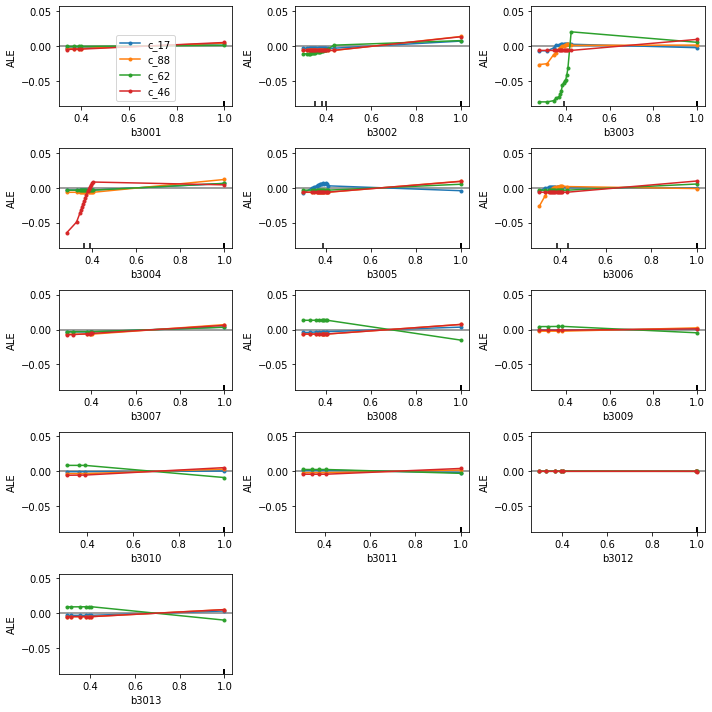

In [12]:
plot_ale(probs_exp, fig_kw={'figwidth': 10, 'figheight': 10});

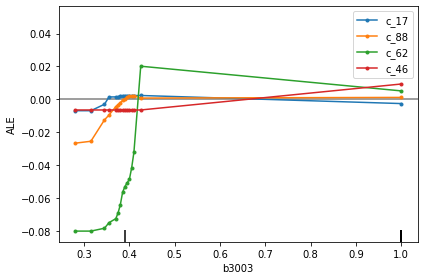

In [13]:
plot_ale(probs_exp, features=[2]);